[View in Colaboratory](https://colab.research.google.com/github/rahutchinson/StudentLoanPaymentSandbox/blob/master/StudnetLoanPaymentCalculator.ipynb)

# Student Loan Most Efficient Pay Off Schedule

HIGH RATE ONLY                                                                                                                                                                                                             

# Setup


You need the basics. 

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt


#Debt Group Definition

In [0]:
class Group:
  def __init__(self, group_name,group_rate,group_princp, _active, _min_pay):
    self.name = group_name
    self.rate = group_rate
    self.active = _active
    self.daily_rate = group_rate/365.25
    self.principal = group_princp
    self.history = pd.DataFrame(index=range(0,2000), columns=['Principal', 'Day Cost'])
    self.day = 0
    self.min_pay = _min_pay
    self.payments = []
    self.done = None
    
    """
     This function calculates and adds the daily interest for the object.
     
    """
  def add_daily_interest(self):
    if(self.active):
      self.principal = round((self.principal + (self.principal * self.daily_rate)),2)
      
    """
     This function pays the minimum payment of the debt group
     
     Returns:
        The amount paid as a float
    """
  def pay_min(self):
    total = self.payment(self.min_pay)
    if(total != 0):
      return total
    return self.min_pay
  
  """
     This function is a day iteration it:
        - adds the daily interest to the principal
        - adds the principal and daily cost to the history dataframe
        - checks to see if it is paid off and marks if it is
        - iterates the interal day clock
    """
  def record(self):
    self.add_daily_interest()
    self.history.iat[self.day, 0]=self.principal
    self.history.iat[self.day, 1]=self.per_day_cost()
    self.day = self.day + 1
    """
    This function takes payments and walks through making the payment and returning whats left

    Args: 
      amount: the amount wanted to pay

    Returns:
      a float that has the amount leftover after paying off group
    """
  def payment(self, amount):
    if(amount > self.principal):
      amount = amount-self.principal
      paid = self.principal
      self.principal = 0
      self.payments.append([self.day,paid, self.principal])
      self.done = self.day
      self.rate = 0
      self.active = False
      return amount
    else:
      self.principal = self.principal - amount
      self.payments.append([self.day, amount, self.principal])
      return 0
    
  """
     This function calculates the current daily cost for the object
    
     Returns:
        a float that is the daily cost if active
  """
  def per_day_cost(self):
    if(self.active):
      return self.principal * self.daily_rate
    return 0

# Payment Exploration & Results


## Experiment Function



In [0]:
"""
This function is the experiment with high rate vs high daily cost payment

Args:
    Groups: List of active groups to make payments on
    mon_payment: the monthly payment user wants to make
    rate: the flag to switch from high_rate to high_daily

Returns:
  The leftover of the mon_payment if overpaid

Raises:
    None
"""

def payment_strat(Groups, mon_payment,rate):
  #find hightest interest rate
  if(any(group.active == True for group in groups)):
    high_rate_group_rate = max(group.rate for group in Groups if group.active)
    high_rate_group = None
    for group in Groups:
      if(group.rate == high_rate_group_rate and group.active):
        high_rate_group = group
        break
        
    #Pay it and give back the leftover if amount more than principal
    left_over = 0
    if(rate):
      left_over = high_rate_group.payment(mon_payment)
    else:
      left_over = high_cost_group.payment(mon_payment)
      
    return round(left_over,2)
  else:
    return -1

## Main Munch
This is where you actully input data

### Min Payments
This is going to depend on how your loans are calculated. If you groups have different minimum payments then you can input them in the class definition but if they don't figure out how your provider calculates them and put that function in. 

Begining Total: $27201.62
Amount Paid: $28197.35
Monthly Payment: $1200
Intrest Paid: 995.7299999999996
Months Taken: 24
Paid off Date: 
	A: 192
	B: 0
	C: 448
	D: 512
	E: 736
	G: 320


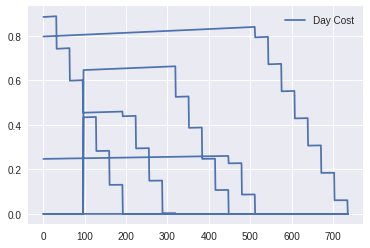

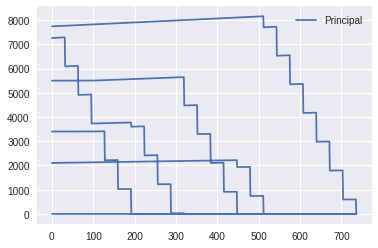

In [55]:
#@title High Rate
HIGH_RATE = True 
MON_PAYMENT = 1200 #@param {type: "number"}
MONTH_CROSSOVER = 4 #@param {type: "number"} months until grace period

#True = high rate model
#False = high daily cost model
PAYMENT_TIME = 31
MIN_PAY = 0

'''(name, interest rate, principal, Subsidized, Min Payment amount)'''
A = Group("A", .0466, 3400.00, False,MIN_PAY)
B = Group("B", .0466, 796.08, True,MIN_PAY)
C = Group("C", .0429, 5500.00, False,MIN_PAY)
D = Group("D", .0429, 2103.66, True,MIN_PAY)
E = Group("E", .0376, 7739.26, True,MIN_PAY)
G = Group("G", .0445, 7662.62, True,MIN_PAY)


groups = [A,B,C,D,E,G]
total_principal = 0

# Total Principal
for group in groups:
  total_principal += round(group.principal,2)

# Main Munch
month_watch = 0
month_count = 0
while any(group.active == True for group in groups):
  leftover = 0
  if(month_watch == 0):
    leftover = MON_PAYMENT
    while leftover > 0:
      leftover = payment_strat(groups, leftover, HIGH_RATE)
    for group in groups:
      group.record()
    month_watch = PAYMENT_TIME
    month_count +=1
    if(month_count == MONTH_CROSSOVER):
      for group in groups:
        if(group.active == False and group.done == None):
          group.active = True
  else:
    for group in groups:
      group.record()
    month_watch -=1

histories = [A.history, B.history,C.history, D.history,E.history,G.history]
plt.figure()
concated = pd.concat(histories)

concated.plot(y='Day Cost')
concated.plot(y='Principal')
total = 0
for group in groups:
  for payment in group.payments:
    total += payment[1]
    
print("Begining Total: $" + str(total_principal))
print("Amount Paid: $" + str(total))
print("Monthly Payment: $" + str(MON_PAYMENT))
print("Intrest Paid: " + str(total-total_principal))
print("Months Taken: " + str(month_count))
print("Paid off Date: ")
print("\tA: " + str(A.done))
print("\tB: " + str(B.done))
print("\tC: " + str(C.done))
print("\tD: " + str(D.done))
print("\tE: " + str(E.done))
print("\tG: " + str(G.done))